In [1]:
import os
from scipy.io import wavfile
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from python_speech_features import mfcc

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, BatchNormalization, MaxPool2D,
                                     GlobalAveragePooling2D, Dense, Dropout,
                                     Flatten, GRU, Reshape, Permute)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# fijamos semilla
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=4096, rate=16000):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)

config = Config(mode='conv')

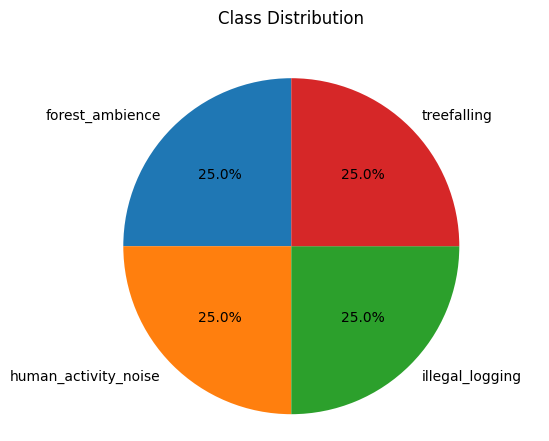

In [3]:
df = pd.read_csv('dataset_balanceado_2.csv')
df.set_index('filename', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('dataset_wavfiles/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

n_samples = 2 * int(df['length'].sum()/0.1)
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [4]:
import math

def build_rand_feat():
    X_list = []
    y_list = []

    # Parámetros MFCC (python_speech_features por defecto)
    winlen = 0.025
    winstep = 0.01
    numcep = config.nfeat

    # calcular número esperado de frames por cada sample (segundos = step / rate)
    step_seconds = config.step / config.rate
    expected_frames = int(math.floor((step_seconds - winlen) / winstep) + 1) if step_seconds > winlen else 1
    # podemos usar expected_frames como tamaño fijo; si quieres otro valor, cambia aquí
    target_frames = expected_frames

    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p = prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('dataset_wavfiles/'+file)

        # stereo -> mono
        if wav.ndim == 2:
            wav = wav.mean(axis=1)
        # asegurar float32 y escala relativa (opcional)
        wav = wav.astype(np.float32)
        # normalizar amplitud si están en int16 por ejemplo (opcional)
        # if wav.dtype == np.int16:
        #     wav = wav / 32768.0

        label = df.at[file, 'label']

        # cortar/pad para tener exactamente config.step muestras (ya lo hacías)
        if wav.shape[0] < config.step:
            pad_width = config.step - wav.shape[0]
            wav = np.pad(wav, (0, pad_width), mode='constant')
        if wav.shape[0] == config.step:
            sample = wav
        else:
            start = np.random.randint(0, wav.shape[0] - config.step)
            sample = wav[start:start + config.step]

        # MFCC: devuelve (n_frames, numcep) -> transponemos a (numcep, frames)
        mfcc_feat = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T
        # mfcc_feat.shape == (numcep, n_frames_variable)

        # --- Asegurar forma homogénea: padding o truncado en axis temporal (axis=1)
        if mfcc_feat.shape[1] < target_frames:
            pad_w = target_frames - mfcc_feat.shape[1]
            mfcc_feat = np.pad(mfcc_feat, ((0,0),(0,pad_w)), mode='constant')
        elif mfcc_feat.shape[1] > target_frames:
            mfcc_feat = mfcc_feat[:, :target_frames]

        # Dependiendo del modo, guardamos de forma consistente
        if config.mode == 'conv':
            # Guardamos (numcep, frames) -> luego reshape a (numcep, frames, 1)
            X_list.append(mfcc_feat)
        elif config.mode == 'time':
            # LSTM/TimeDistributed espera (frames, numcep)
            X_list.append(mfcc_feat.T)
        elif config.mode == 'vector':
            # vector fijo: promedio sobre frames -> shape (numcep,)
            X_list.append(np.mean(mfcc_feat, axis=1))
        else:
            raise ValueError("config.mode debe ser 'conv', 'time' o 'vector'")

        y_list.append(classes.index(label))

    # Convertir a numpy (ahora todas las entradas son homogéneas)
    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.int32)

    # Normalización global (evita usar _min/_max mal calculados)
    X_min = X.min()
    X_max = X.max()
    X = (X - X_min) / (X_max - X_min + 1e-9)

    # Ajustar shapes para keras
    if config.mode == 'conv':
        # X tiene shape (N, numcep, frames) -> queremos (N, numcep, frames, 1)
        X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))
    elif config.mode == 'time':
        # X está (N, frames, numcep) -> OK para LSTM/TimeDistributed
        pass
    elif config.mode == 'vector':
        # X está (N, numcep) -> OK para Dense
        pass

    y = to_categorical(y, num_classes=len(classes))
    return X, y, X_min, X_max, target_frames

X, y, X_min, X_max, target_frames = build_rand_feat()

100%|██████████| 158000/158000 [16:24<00:00, 160.55it/s]


In [5]:
# Cargar el archivo
data = np.load("features_dataset_2.npz", allow_pickle=True)

# Recuperar variables
X = data["X"]
y = data["y"]
X_min = data["X_min"].item()
X_max = data["X_max"].item()
target_frames = data["target_frames"].item()

print("✅ Features cargadas. Shape X:", X.shape, "Shape y:", y.shape)

✅ Features cargadas. Shape X: (158000, 8, 13) Shape y: (158000, 4)


In [7]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.2, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (101120, 13, 8, 1) (101120, 4)
Val: (25280, 13, 8, 1) (25280, 4)
Test: (31600, 13, 8, 1) (31600, 4)


In [8]:
from tensorflow.keras import layers, models
import tensorflow as tf

def get_cnn_gru(input_shape, num_classes=4):
    inputs = layers.Input(shape=input_shape)

    # --- Bloque CNN ---
    x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    # --- Preparar para GRU ---
    x = layers.Permute((2,1,3))(x)   # (batch, time, freq, channels)
    x = layers.Reshape((-1, x.shape[2]*x.shape[3]))(x)

    # --- GRU temporal (más livianas que antes) ---
    x = layers.GRU(48, return_sequences=True)(x)
    x = layers.GRU(48)(x)

    # --- Clasificador final ---
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(48, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 13, 8, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 8, 16)      │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 13, 8, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 6, 4, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 6, 4, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 3, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_4 (Permute)             │ (None, 2, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 2, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 2, 48)          │        21,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 48)             │        14,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,676 (166.70 KB)

 Trainable params: 42,580 (166.33 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/50
3160/3160 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.6678 - loss: 0.8131 - val_accuracy: 0.6909 - val_loss: 0.7545 - learning_rate: 0.0010
Epoch 2/50
3160/3160 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.7545 - loss: 0.6332 - val_accuracy: 0.7165 - val_loss: 0.7298 - learning_rate: 0.0010
Epoch 3/50
3160/3160 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.7861 - loss: 0.5611 - val_accuracy: 0.7869 - val_loss: 0.5469 - learning_rate: 0.0010
Epoch 4/50
3160/3160 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8037 - loss: 0.5159 - val_accuracy: 0.7738 - val_loss: 0.5906 - learning_rate: 0.0010
Epoch 5/50
3160/3160 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8167 - loss: 0.4840 - val_accuracy: 0.7849 - val_loss: 0.5567 - learning_rate: 0.0010
Epoch 6/50
3160/3160 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8265 - loss: 0.4599 - val_accuracy: 0.7938 - val_loss: 0.5380 - learning_rate: 0.0010
Epoch 7/50
3160/3160 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8

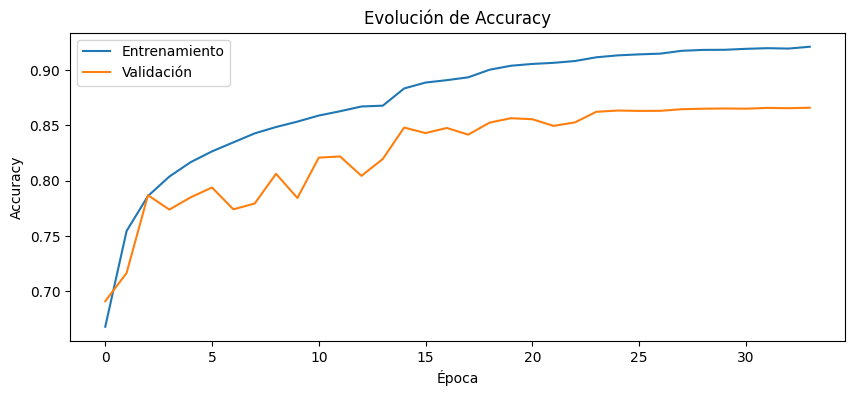

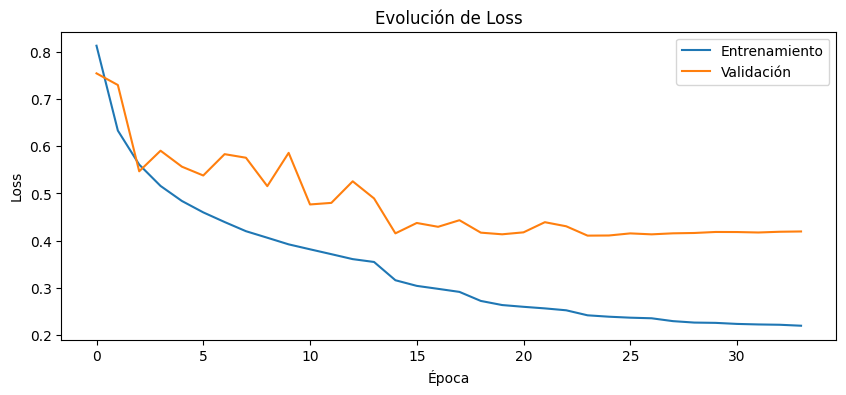

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Crear el modelo
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = get_cnn_gru(input_shape=input_shape, num_classes=4)
model.summary()

# Callbacks para controlar entrenamiento
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# Entrenar
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# --- Graficar métricas ---
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Evolución de Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Evolución de Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

988/988 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8634 - loss: 0.4063
Test Accuracy: 0.8634, Test Loss: 0.4063
988/988 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Classification Report:

                      precision    recall  f1-score   support

     forest_ambience     0.8502    0.8624    0.8562      7898
human_activity_noise     0.8214    0.8007    0.8109      7754
     illegal_logging     0.8973    0.8359    0.8655      7922
         treefalling     0.8834    0.9520    0.9164      8026

            accuracy                         0.8634     31600
           macro avg     0.8631    0.8628    0.8623     31600
        weighted avg     0.8634    0.8634    0.8627     31600



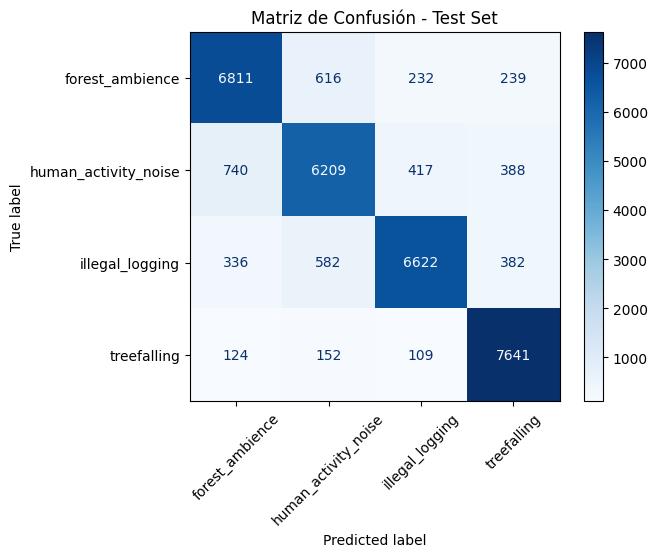

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Evaluar en el set de prueba
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Reporte detallado
target_names = classes

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=target_names, digits=4))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de Confusión - Test Set")
plt.show()


In [36]:
from scipy.signal import resample_poly
import numpy as np

def predict_audio_file(file_path, model, config, classes, X_min, X_max, target_frames,
                       window_stride=None, top_k=3, verbose=False):

    # 1) Cargar
    rate, wav = wavfile.read(file_path)

    # 2) mono y float32
    if wav.ndim == 2:
        wav = wav.mean(axis=1)
    wav = wav.astype(np.float32)

    # 4) ventana y stride
    if window_stride is None:
        window_stride = config.step // 2  # 50% overlap (puedes cambiar)

    preds_list = []

    # si el audio es más corto que config.step, hacemos un único padding
    if wav.shape[0] <= config.step:
        seg = np.pad(wav, (0, config.step - wav.shape[0]), mode='constant')
        starts = [0]
    else:
        starts = list(range(0, wav.shape[0] - config.step + 1, window_stride))
        # incluir última ventana para cubrir cola
        if (wav.shape[0] - config.step) % window_stride != 0:
            starts.append(wav.shape[0] - config.step)

    for s in starts:
        seg = wav[s:s + config.step]
        if seg.shape[0] < config.step:
            seg = np.pad(seg, (0, config.step - seg.shape[0]), mode='constant')

        # extraer MFCC (misma llamada que en build_rand_feat)
        mfcc_feat = mfcc(seg, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T

        # padding/truncado temporal a target_frames (mismo comportamiento que en build_rand_feat)
        if mfcc_feat.shape[1] < target_frames:
            pad_w = target_frames - mfcc_feat.shape[1]
            mfcc_feat = np.pad(mfcc_feat, ((0,0),(0,pad_w)), mode='constant')
        elif mfcc_feat.shape[1] > target_frames:
            mfcc_feat = mfcc_feat[:, :target_frames]

        # Normalizar usando X_min/X_max del entrenamiento (scalar)
        mfcc_norm = (mfcc_feat - X_min) / (X_max - X_min + 1e-9)

        # Preparar input según modo
        if config.mode == 'conv':
            # usar config.nfeat y target_frames, no el shape calculado localmente
            x_in = mfcc_norm.reshape(1, config.nfeat, target_frames, 1)
        elif config.mode == 'time':
            x_in = mfcc_norm.T.reshape(1, target_frames, config.nfeat)
        elif config.mode == 'vector':
            x_in = np.mean(mfcc_norm, axis=1).reshape(1, config.nfeat)
        else:
            raise ValueError("config.mode debe ser 'conv','time' o 'vector'")


        # Predecir y guardar softmax vector
        prob = model.predict(x_in, verbose=0)[0]
        preds_list.append(prob)

    # Promediar probabilidades (soft-voting)
    preds_arr = np.array(preds_list)
    avg_prob = preds_arr.mean(axis=0)

    # Top-k
    top_idx = avg_prob.argsort()[-top_k:][::-1]
    top_results = [(classes[i], float(avg_prob[i])) for i in top_idx]


    # info adicional
    if verbose:
        print(f"Num ventanas: {len(preds_list)}, stride (samples): {window_stride}")
        for cls, p in top_results:
            print(f"{cls}: {p:.4f}")

    return top_results, avg_prob

# Ejemplo de uso:
# Asegúrate de usar 'classes' en el mismo orden que el used para to_categorical (p. ej. classes = list(np.unique(df.label)))
# X_min, X_max, target_frames vienen de: X, y, X_min, X_max, target_frames = build_rand_feat()
file_path = "dataset_wavfiles/3_10307.wav"
top_results, avg_prob = predict_audio_file(file_path, model, config, classes, X_min, X_max, target_frames, verbose=True)
print("Top resultados:", top_results)

Num ventanas: 275, stride (samples): 800
forest_ambience: 0.6633
human_activity_noise: 0.3092
treefalling: 0.0217
Top resultados: [('forest_ambience', 0.663301944732666), ('human_activity_noise', 0.30924955010414124), ('treefalling', 0.021653268486261368)]


In [49]:
# --- BLOQUE 10: Inferencia con audios propios (versión corregida) ---

import librosa
import tensorflow.keras.backend as K

def predict_audio(file_path, model, config, X_min, X_max, target_frames, classes):
    # 1. Cargar audio
    wav, sr = librosa.load(file_path, sr=config.rate)

    # 2. Pad o recorte
    if len(wav) < config.step:
        pad_width = config.step - len(wav)
        wav = np.pad(wav, (0, pad_width), mode='constant')
    else:
        start = np.random.randint(0, len(wav) - config.step + 1)
        wav = wav[start:start + config.step]

    # 3. MFCC
    mfcc_feat = mfcc(
        wav, sr,
        numcep=config.nfeat,
        nfilt=config.nfilt,
        nfft=config.nfft
    ).T  # (numcep, frames)

    # 4. Padding / truncado
    if mfcc_feat.shape[1] < target_frames:
        pad_w = target_frames - mfcc_feat.shape[1]
        mfcc_feat = np.pad(mfcc_feat, ((0,0),(0,pad_w)), mode='constant')
    elif mfcc_feat.shape[1] > target_frames:
        mfcc_feat = mfcc_feat[:, :target_frames]

    # 5. Normalización
    mfcc_feat = (mfcc_feat - X_min) / (X_max - X_min + 1e-9)

    # 6. Ajuste de shape
    if config.mode == 'conv':
        X_input = mfcc_feat.reshape(1, mfcc_feat.shape[0], mfcc_feat.shape[1], 1)
    elif config.mode == 'time':
        X_input = mfcc_feat.T.reshape(1, mfcc_feat.shape[1], mfcc_feat.shape[0])
    elif config.mode == 'vector':
        X_input = np.mean(mfcc_feat, axis=1).reshape(1, -1)
    else:
        raise ValueError("Modo inválido")

    # 7. Predicción segura
    preds = model.predict(X_input, verbose=0)
    pred_class = np.argmax(preds, axis=1)[0]
    pred_label = classes[pred_class]

    return pred_label, preds[0]


# --- Ejemplo de uso ---
file_path = "Grabación (3).wav"
label, probs = predict_audio(file_path, model, config, X_min, X_max, target_frames, classes)

print("🎧 Archivo:", file_path)
print("🔮 Predicción:", label)
print("📊 Probabilidades por clase:")
for cls, p in zip(classes, probs):
    print(f"{cls}: {p:.4f}")



🎧 Archivo: Grabación (3).wav
🔮 Predicción: illegal_logging
📊 Probabilidades por clase:
forest_ambience: 0.0001
human_activity_noise: 0.0002
illegal_logging: 0.9997
treefalling: 0.0000


In [22]:
import tensorflow as tf
import os

# === 1. Guardar modelo en formato .keras ===
model.save("CNN_GRU_model.keras")
print("Modelo guardado en: CNN_GRU_model.keras")

# === 2. Cargar el modelo para convertir ===
loaded_model = tf.keras.models.load_model("CNN_GRU_model.keras")

# === 3. Convertir a TFLite con soporte para GRU ===
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)

# Permitir ops extendidas de TensorFlow (necesario para GRU/LSTM)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,   # Operaciones nativas TFLite
    tf.lite.OpsSet.SELECT_TF_OPS      # Agregar soporte para GRU/LSTM
]

# Desactivar el intento de reducir TensorList (incompatible con GRU)
converter._experimental_lower_tensor_list_ops = False

# Convertir
tflite_model = converter.convert()

# Guardar el modelo TFLite
os.makedirs("TinyML_modelos", exist_ok=True)
tflite_path = "TinyML_modelos/CNN_GRU_model.tflite"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)
print(f"Modelo TFLite guardado en: {tflite_path}")

# === 4. Comparar tamaños en MB ===
savedmodel_size = os.path.getsize("CNN_GRU_model.keras")
tflite_size = os.path.getsize(tflite_path)

print(f"Tamaño Keras (.keras): {savedmodel_size / (1024):.2f} KB")
print(f"Tamaño TFLite:        {tflite_size / (1024):.2f} KB")
print(f"Reducción: {100*(1 - tflite_size/savedmodel_size):.2f}%")



Modelo guardado en: CNN_GRU_model.keras
INFO:tensorflow:Assets written to: C:\Users\W11\AppData\Local\Temp\tmpah1_gqc5\assets


INFO:tensorflow:Assets written to: C:\Users\W11\AppData\Local\Temp\tmpah1_gqc5\assets


Saved artifact at 'C:\Users\W11\AppData\Local\Temp\tmpah1_gqc5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 13, 8, 1), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2564132363088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2564132360592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2566289653200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2564396592656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2566289652240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2566289652432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2564396593040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2566289651280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2566224667728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2566289652816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  256622466